## Likelihood-Based Fitting
> Example-driven review and analysis of what likelihood-based fitting tells us about model performance. Make clear case, add reflection on limitations and potential extensions. Include account of how prediction errors are often appropriate outcomes, and thus how log-likelihood scores are ambiguous.

In [4]:
#| code-summary: code -- load dependencies and data

from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data, simulate_array
from compmemlearn.analyses import fast_csp
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../data/mo1970.txt')

In [2]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 32123.2
differential_evolution step 2: f(x)= 32123.2
differential_evolution step 3: f(x)= 28473
differential_evolution step 4: f(x)= 28138.1
differential_evolution step 5: f(x)= 27812.4
differential_evolution step 6: f(x)= 25920.8
differential_evolution step 7: f(x)= 24898.5
differential_evolution step 8: f(x)= 24898.5
differential_evolution step 9: f(x)= 24898.5
differential_evolution step 10: f(x)= 24898.5
differential_evolution step 11: f(x)= 24547
differential_evolution step 12: f(x)= 24356.3
differential_evolution step 13: f(x)= 24000.5
differential_evolution step 14: f(x)= 24000.5
differential_evolution step 15: f(x)= 24000.5
differential_evolution step 16: f(x)= 23637.6
differential_evolution step 17: f(x)= 23637.6
differential_evolution step 18: f(x)= 23537.1
differential_evolution step 19: f(x)= 23537.1
differential_evolution step 20: f(x)= 23364.3
differential_evolution step 21: f(x)= 23364.3
differential_evolution step 22: f(x)= 23364.3
d

In [3]:
#| include: false
print(cmr_result)

     fun: 22723.684475175505
     jac: array([-3.40442055, -9.23828338,  1.14523572, -2.03035596, -0.69630914,
       -9.10040399,  0.07530616,  0.        , -9.23973857,  2.15331966,
       -1.7706043 , -1.51776475])
 message: 'Optimization terminated successfully.'
    nfev: 9306
     nit: 39
 success: True
       x: array([5.72765379e-01, 3.53142919e-03, 7.30980113e-01, 5.23429968e-01,
       9.55669115e-01, 8.78955476e-02, 1.05704981e+01, 4.26968288e+01,
       3.13459805e-02, 3.36895609e-01, 6.89906963e+00, 9.96122507e-01])


In [5]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

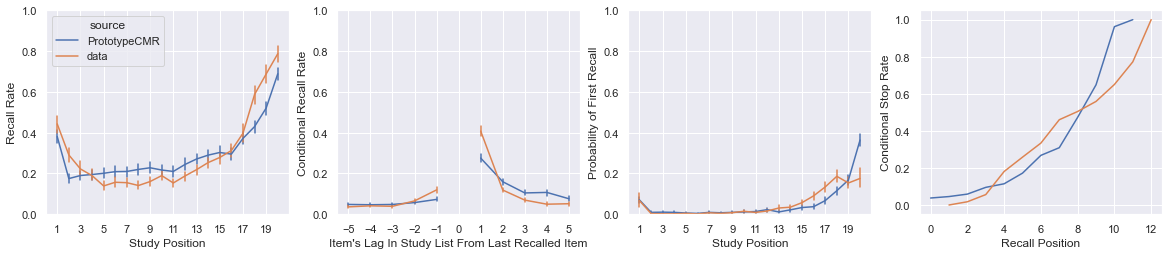

In [30]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')